<a href="https://colab.research.google.com/github/calistasalscpw/Selena-Finance-Tracker/blob/main/Selena_Shopee_rev_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone Project - Selena (Shopee)

**Proses Analisis oleh Model ML (Menggunakan File .pkl)**

- **Backend kemudian memuat model ML yang sudah dilatih (disimpan dalam format .pkl) menggunakan library Pickle di Python.**
- Model ML ini memproses data transaksi pengguna yang sudah diambil dari database untuk melakukan beberapa tugas analisis:
    - Arus Kas: Mengidentifikasi pola pemasukan dan pengeluaran.
    - Saran Keuangan: Berdasarkan analisis tren keuangan pengguna, model bisa memberikan saran, misalnya mengurangi pengeluaran di kategori tertentu.
    - Deteksi Anomali Pengeluaran: Model ML mendeteksi adanya transaksi atau pengeluaran yang tidak biasa atau mencurigakan.

Pengembalian Hasil Analisis ke Backend (ML ke CC)

- Model ML menghasilkan output analisis, seperti rekomendasi keuangan atau deteksi anomali, yang dikonversi ke **format JSON**.
- Backend menerima hasil ini dan menggabungkannya menjadi satu respons JSON yang siap dikirim ke aplikasi mobile.

## Import Libraries

In [4]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd

## Preprocessing Data

In [5]:
#FUNGSI UNTUK PREPROCESSING DATA

def preprocess_data(data_path):
  # Membaca file dataset
  read_file = pd.read_excel(data_path)
  read_file.to_csv("./data/dataset.csv", index=None, header=True)
  df = pd.DataFrame(pd.read_csv("./data/dataset.csv"))

  # Mengambil kolom yang dibutuhkan
  data_filtered = df[['Waktu Pesanan Selesai', 'Total Pembayaran']].copy()

  # Menghapus titik dari kolom 'Total Pembayaran'
  data_filtered['Total Pembayaran'] = data_filtered['Total Pembayaran'].astype(str).str.replace('.', '', regex=False)

  # Mengkonversi tipe data
  data_filtered['Total Pembayaran'] = pd.to_numeric(data_filtered['Total Pembayaran'])
  data_filtered['Waktu Pesanan Selesai'] = pd.to_datetime(data_filtered['Waktu Pesanan Selesai']).dt.date

  # Menghapus pesanan yang dibatalkan/tidak selesai
  data_final = data_filtered[data_filtered['Total Pembayaran'] != 0]

  # Assign value variabel time dan series
  time = data_final['Waktu Pesanan Selesai'].tolist()
  series = data_final['Total Pembayaran'].tolist()

  return time, series

## Preprocessing Data and Global Variables

Fungsi `preprocess_data` sudah melakukan preprocessing dari membaca dataset, memilih kolom yang dibutuhkan, serta parsing data.

In [6]:
### Inisiasi variabel global ###

DATA_PATH = './data/Order.completed.20240903_20241003.xlsx'
TIME, SERIES = preprocess_data(DATA_PATH)

# Model
SPLIT_TIME = 90
WINDOW_SIZE = 7
BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = 100

## Defining Functions
---



Terdiri atas beberapa fungsi:
- Fungsi `plot_series`: Berisi matplotlib untuk visualisasi data berupa time series
- Fungsi `train_val_split`: Digunakan untuk membagi time series menjadi data latih dan data validasi
- Fungsi `create_windowed_dataset`: Digunakan untuk membuat dataset berbentuk windowed

In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(16, 8))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))  # Menyesuaikan format tanggal
    plt.gcf().autofmt_xdate()  # Memutar tanggal agar tidak bertabrakan
    plt.show()

In [8]:
def train_val_split(time, series):
    """Split time series into train and validation sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [9]:
def create_windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    """
    Membuat dataset dalam bentuk windowed untuk time series.

    Parameters:
    - series: Data time series dalam bentuk array atau list.
    - window_size: Jumlah langkah dalam satu jendela input.
    - batch_size: Jumlah data yang diproses dalam satu batch.
    - shuffle_buffer: Ukuran buffer untuk pengacakan data.

    Returns:
    - dataset: Dataset dengan pasangan input-output berdasarkan window size.
    """

    # Konversi data series ke dalam dataset tensorflow
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Membuat window untuk setiap sample
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Konversi setiap window ke dalam bentuk batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Memisahkan window menjadi input (features) dan output (label)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Mengacak data menggunakan shuffle buffer
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Membuat batch data
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [53]:
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.2),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [54]:
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """

    model = create_uncompiled_model()

    model.compile(loss = tf.keras.losses.Huber(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["mae"])

    return model

## Plot Series

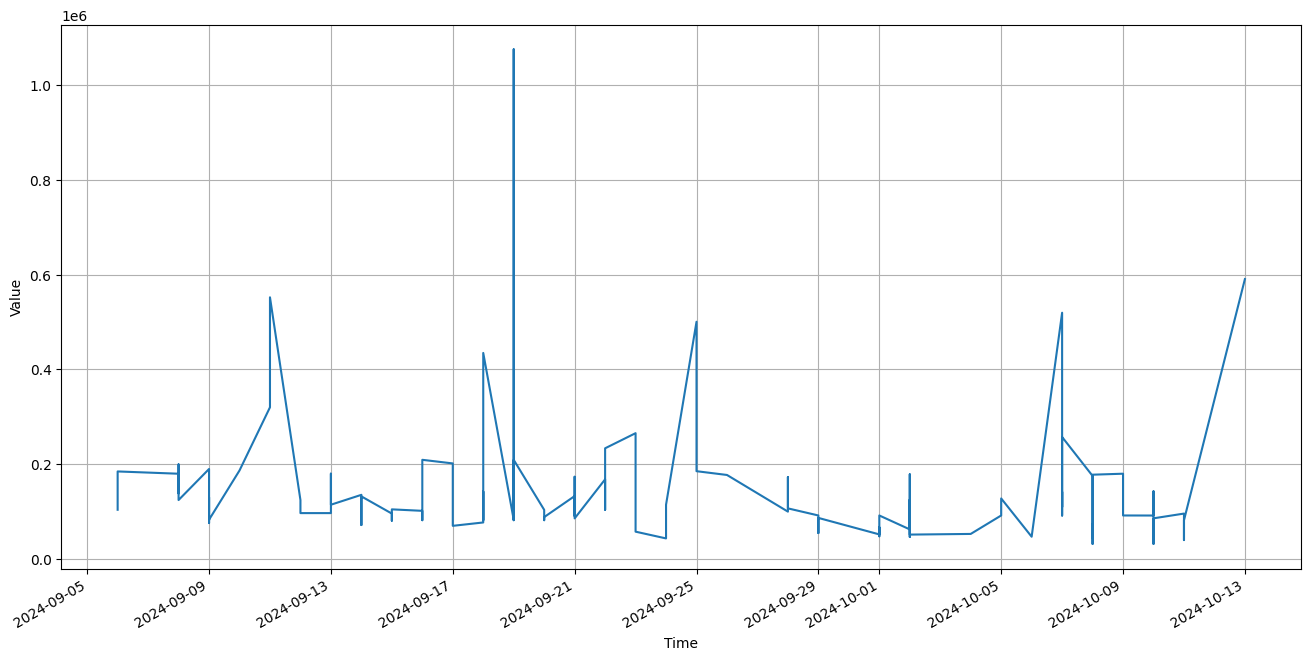

In [55]:
plot_series(TIME, SERIES)

In [56]:
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)
series_train_windowed = create_windowed_dataset(series_train)

# model
uncompiled_model = create_uncompiled_model()

In [57]:
example_batch = series_train_windowed.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (4, 1)


c:\Program Files\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [58]:
model = create_model()

In [59]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

history = model.fit(series_train_windowed, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 158711.4844 - mae: 158711.9844 - learning_rate: 1.0000e-08
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 154212.9688 - mae: 154213.4531 - learning_rate: 1.1220e-08
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 149055.6875 - mae: 149056.1875 - learning_rate: 1.2589e-08
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 158297.8125 - mae: 158298.3125 - learning_rate: 1.4125e-08
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 150269.4531 - mae: 150269.9531 - learning_rate: 1.5849e-08
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 150983.9375 - mae: 150984.4375 - learning_rate: 1.7783e-08
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 131628.7969 - mae: 131629.2969 - learning_rate: 1.9953e-08
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 168066.6562 - mae: 168067.1562 - learning_rate: 2.2387e-08
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - los

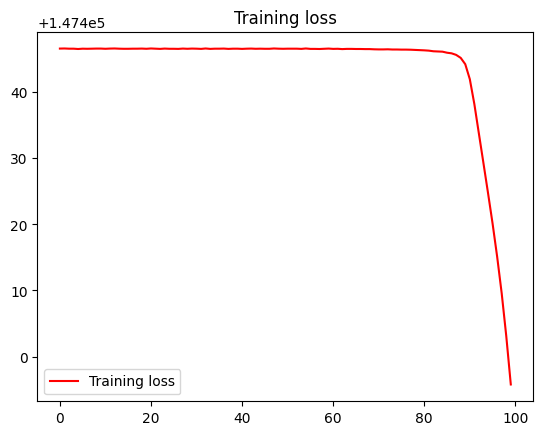

In [60]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

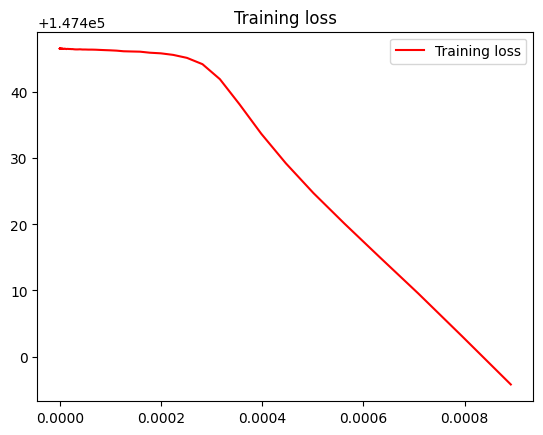

In [61]:
# Plot the training loss for each learning rate

loss = history.history['loss']

lr = history.history['learning_rate']

plt.plot(lr, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluate Forecast

Using MAE and MSE as metrics to evaluate forecast (prediction)

In [62]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

More efficient way to forecast

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [63]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [64]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


<Figure size 1000x600 with 0 Axes>

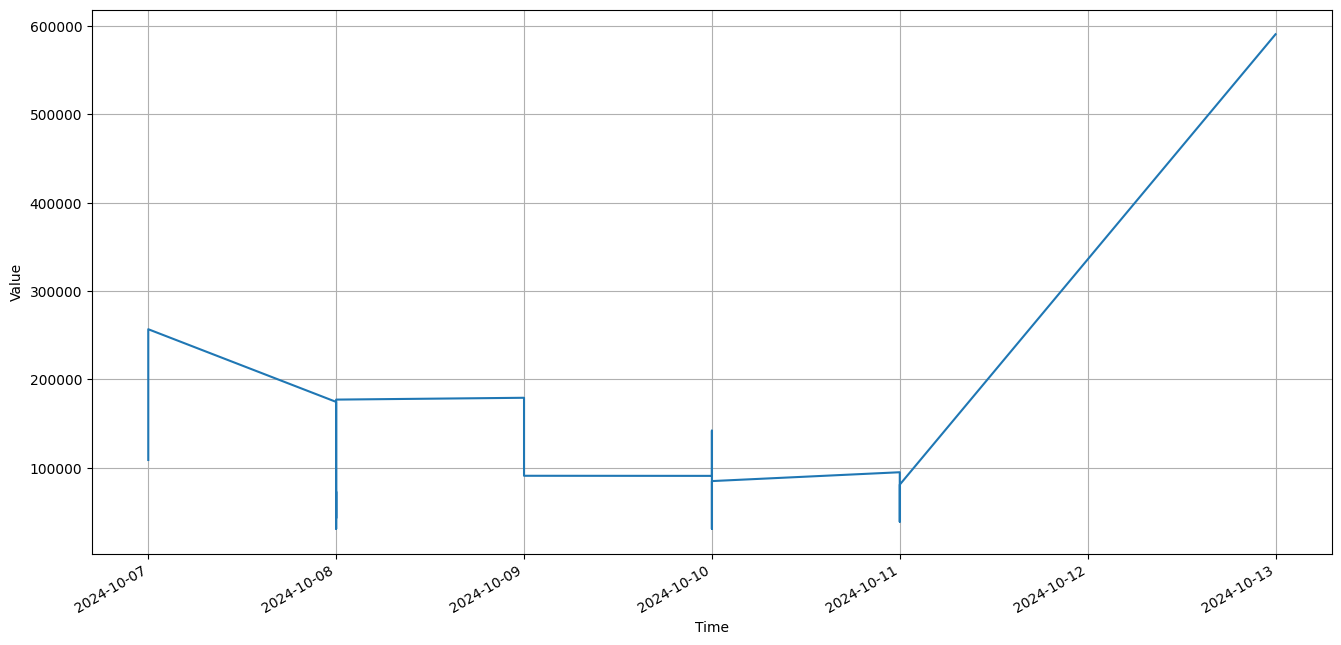

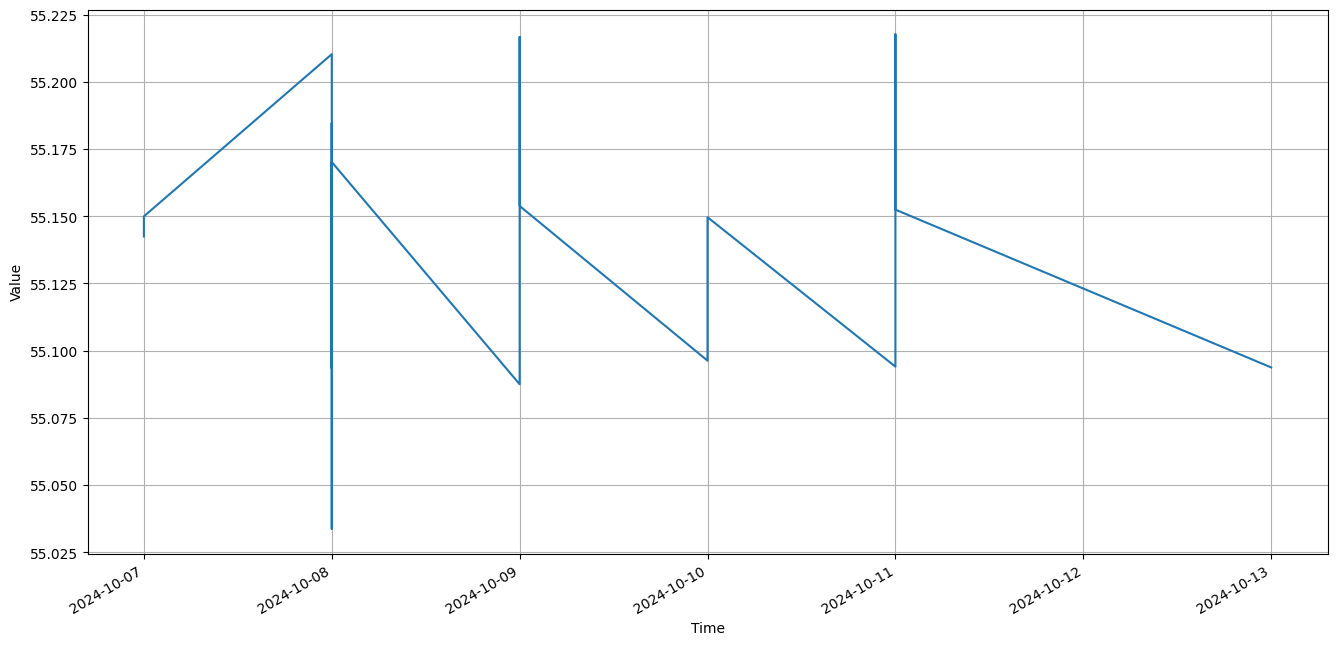

In [65]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [66]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 30391801856.00, mae: 127001.91 for forecast
